In [2]:
import numpy as np
import random
import json
from datetime import datetime, timedelta
import os

def generate_synthetic_event(event_type, current_time, time_delta):
    event = {
        'timestamp': current_time.isoformat(),
        'type': event_type,
        'time_delta': time_delta.total_seconds(),
        'data': {}
    }
    if event_type == 'gaze_data':
        event['data']['adjusted_gaze_start_position'] = [random.uniform(0, 1920), random.uniform(0, 1080)]
    elif event_type == 'mouse_movement':
        event['data']['start_position'] = [random.uniform(0, 1920), random.uniform(0, 1080)]
        event['data']['end_position'] = [random.uniform(0, 1920), random.uniform(0, 1080)]
    elif event_type == 'mouse_click':
        event['data']['position'] = [random.uniform(0, 1920), random.uniform(0, 1080)]
        event['data']['button'] = random.choice(['left', 'right'])
    elif event_type == 'keyboard_session':
        start_time = current_time
        end_time = start_time + timedelta(milliseconds=random.randint(100, 5000))
        event['data']['start_time'] = start_time.isoformat()
        event['data']['end_time'] = end_time.isoformat()
    
    return event

def generate_synthetic_session(num_events=1000, focus_level=5):
    event_types = ['gaze_data', 'mouse_movement', 'mouse_click', 'keyboard_session']
    
    # Adjust the number of events based on the focus level
    if focus_level == 0:
        num_events = random.randint(50, 200)
    elif focus_level < 5:
        num_events = random.randint(200, 500)
    elif focus_level < 8:
        num_events = random.randint(500, 1000)
    else:
        num_events = random.randint(1000, 1500)
    
    session = []
    current_time = datetime.now()
    focus_level_variation = focus_level

    for _ in range(num_events - 1):
        event_type = random.choice(event_types)

        # Higher focus levels may have more gaze data indicating reading or concentrated work
        if focus_level >= 8 and random.random() < 0.7:
            event_type = 'gaze_data'
        
        # Introduce variation in focus level throughout the session
        if random.random() < 0.1:  # 10% chance to vary focus level
            focus_level_variation = max(0, min(10, focus_level + random.choice([-1, 1])))
        
        # Simulate realistic time intervals between events
        time_increment = timedelta(milliseconds=random.randint(100, 1000))
        current_time += time_increment

        # Cluster events during high focus periods
        if focus_level_variation >= 8:
            time_increment = timedelta(milliseconds=random.randint(50, 200))
            current_time += time_increment

        event = generate_synthetic_event(event_type, current_time, time_increment)
        session.append(event)
    
    # Add a single focus_level event at the end
    focus_level_event = generate_synthetic_event('focus_level', current_time, timedelta(milliseconds=0))
    focus_level_event['data']['level'] = focus_level
    session.append(focus_level_event)
    
    return session

def generate_synthetic_data(num_sessions=10):
    synthetic_data = []
    for _ in range(num_sessions):
        focus_level = random.randint(0, 10)
        session = generate_synthetic_session(focus_level=focus_level)
        synthetic_data.append(session)
    return synthetic_data

def save_synthetic_data(synthetic_data, directory):
    for i, session in enumerate(synthetic_data):
        user_folder = f'user_{i+1}'
        date_folder = datetime.now().strftime('%Y-%m-%d')
        
        session_dir = os.path.join(directory, user_folder, date_folder)
        os.makedirs(session_dir, exist_ok=True)
        
        session_path = os.path.join(session_dir, 'activity_log.json')
        with open(session_path, 'w') as f:
            json.dump(session, f, indent=4)  # Indent by 4 spaces

# Usage example
synthetic_data = generate_synthetic_data(num_sessions=50)
save_synthetic_data(synthetic_data, 'synthetic_data_test')


2/2 [==============================] - 2s 35ms/step
F1 Score: 0.5882352941176471


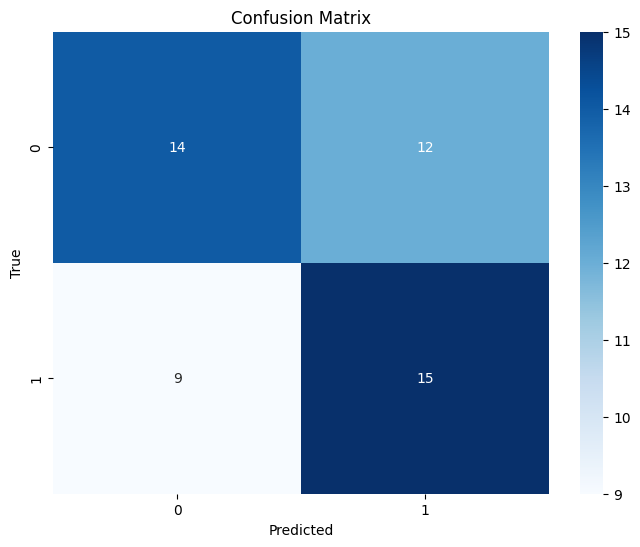

              precision    recall  f1-score   support

           0       0.61      0.54      0.57        26
           1       0.56      0.62      0.59        24

    accuracy                           0.58        50
   macro avg       0.58      0.58      0.58        50
weighted avg       0.58      0.58      0.58        50



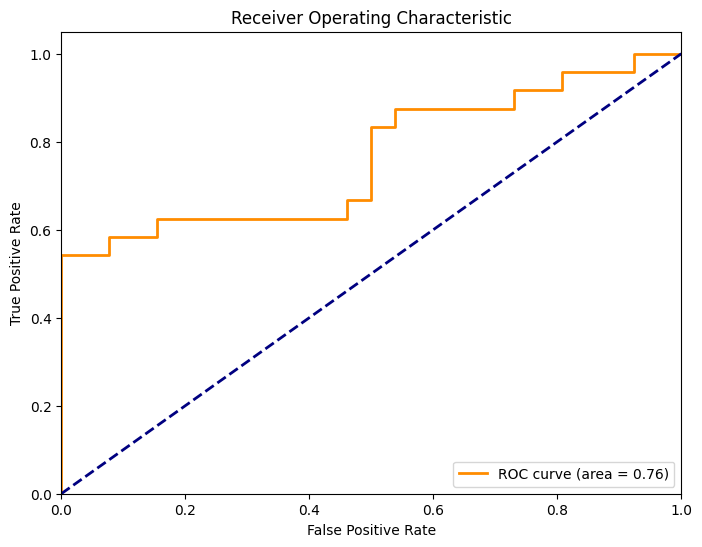

Metrics saved to model_metrics.json


In [4]:
import os
import json
import numpy as np
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model and preprocessors
MODEL_PATH = './model_v2.h5'
ENCODER_PATH = './encoder_v2.pkl'
SCALER_PATH = './scaler_v2.pkl'

# Load the trained model
model = load_model(MODEL_PATH)

# Load encoder and scaler
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

encoder = load_pickle(ENCODER_PATH)
scaler = load_pickle(SCALER_PATH)

# Load test data
def load_json_data(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)
    
def load_data(directory):
    session_data = []
    for user_folder in os.listdir(directory):
        user_path = os.path.join(directory, user_folder)
        if os.path.isdir(user_path):
            for date_folder in os.listdir(user_path):
                date_path = os.path.join(user_path, date_folder)
                activity_file = 'activity_log.json'
                file_path = os.path.join(date_path, activity_file)
                if os.path.isfile(file_path):
                    with open(file_path, 'r') as file:
                        file_data = json.load(file)
                        if isinstance(file_data, list):
                            session_data.append(file_data)  # Each file is one session
    return session_data

test_data = load_data("synthetic_data_test/")
# Preprocess test data
def preprocess_data(session_data, threshold=5):
    all_features = []
    all_labels = []
    for session in session_data:
        features = []
        label = None
        for event in session:
            if 'focus_level' in event['type']:
                focus_level = event['data']['level']
                label = 1 if focus_level > threshold else 0
                if features and label is not None:
                    all_features.append(features)
                    all_labels.append(label)
                features = []
            else:
                event_type = event['type']
                if event_type == 'active_window':
                    continue
                time_delta = event.get('time_delta', event['data'].get('time_delta', 0))
                if event_type == 'gaze_data':
                    position = event['data'].get('adjusted_gaze_start_position', [0, 0])
                elif event_type == 'mouse_movement':
                    start_position = event['data'].get('start_position', [0, 0])
                    end_position = event['data'].get('end_position', [0, 0])
                    position = [(s + e) / 2 for s, e in zip(start_position, end_position)]
                elif event_type == 'mouse_click':
                    position = event['data'].get('position', [0, 0])
                elif event_type == 'keyboard_session':
                    start_time = event['data'].get('start_time', event['timestamp'])
                    end_time = event['data'].get('end_time', event['timestamp'])
                    duration = (np.datetime64(end_time) - np.datetime64(start_time)).astype('timedelta64[ms]').astype(int)
                    position = [duration, 0]
                else:
                    position = [0, 0]
                button = event['data'].get('button', 'None')
                feature = [event['timestamp'], event_type, position, button, time_delta]
                features.append(feature)
    return all_features, all_labels

def encode_features(features, encoder, scaler):
    all_categories = []
    all_time_deltas = []
    for session in features:
        all_categories.extend([[feat[1], feat[3]] for feat in session])
        all_time_deltas.extend([feat[4] for feat in session])

    all_time_deltas = np.array(all_time_deltas).reshape(-1, 1)
    all_time_deltas_normalized = scaler.transform(all_time_deltas).flatten()

    all_sessions = []
    time_delta_index = 0
    for session in features:
        categorical_features = np.array([[feat[1], feat[3]] for feat in session])
        categorical_encoded = encoder.transform(categorical_features).toarray()
        position_data = np.array([feat[2] for feat in session])
        time_deltas = np.array([all_time_deltas_normalized[time_delta_index:time_delta_index+len(session)]])
        time_delta_index += len(session)
        encoded_session = np.hstack((position_data, categorical_encoded, time_deltas.T))
        all_sessions.append(encoded_session)

    return all_sessions

def create_sequences(features, labels, sequence_length=100):
    padded_features = pad_sequences(features, maxlen=sequence_length, padding='post', dtype='float32')
    padded_labels = np.array(labels)
    return padded_features, padded_labels

# Preprocess and encode test data
test_features, test_labels = preprocess_data(test_data)
encoded_test_features = encode_features(test_features, encoder, scaler)
X_test, y_test = create_sequences(encoded_test_features, test_labels)

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0).flatten()

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_test, y_pred))

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Save metrics to a JSON file
metrics = {
    "f1_score": f1,
    "confusion_matrix": conf_matrix.tolist(),
    "classification_report": classification_report(y_test, y_pred, output_dict=True),
    "roc_auc": roc_auc
}

with open("model_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("Metrics saved to model_metrics.json")
